Detectron2 is a popular PyTorch based modular computer vision model library.


[GitHub](https://github.com/facebookresearch/detectron2/tree/main)

In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch torchvision -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!gcc --version
# opencv is pre-installed on colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-xsmg1hm_
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-xsmg1hm_
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=386201 sha256=b3ced9823e1ceeda037009668bc0a54a63005a2be59a392e2842160223ef6feb
  Stored in directory: /tmp/pip-ephem-wheel-cache-bw_m17q3/wheels/39/61/b4/480fbddb4d3d6bc34083e7397b

In [2]:
# install detectron2:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ulu7mt76
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ulu7mt76
  Resolved https://github.com/facebookresearch/detectron2.git to commit 3c7bb714795edc7a96c9a1a6dd83663ecd293e36
  Preparing metadata (setup.py) ... done
  Using cached pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


In [3]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

2.0.1+cu118 True


In [4]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


# Some basic setup:

In [5]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Import and Register Custom Data

[Dataset](https://universe.roboflow.com/tesidataset/cardamagedetection-mnsea)

In [6]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/Colab_Notebooks/ObjectDetection/Detectron2/dataset/CarDamage/train/_annotations.coco.json", "/content/drive/MyDrive/Colab_Notebooks/ObjectDetection/Detectron2/dataset/CarDamage/train")
register_coco_instances("my_dataset_val", {}, "/content/drive/MyDrive/Colab_Notebooks/ObjectDetection/Detectron2/dataset/CarDamage/valid/_annotations.coco.json", "/content/drive/MyDrive/Colab_Notebooks/ObjectDetection/Detectron2/dataset/CarDamage/valid")
register_coco_instances("my_dataset_test", {}, "/content/drive/MyDrive/Colab_Notebooks/ObjectDetection/Detectron2/dataset/CarDamage/test/_annotations.coco.json", "/content/drive/MyDrive/Colab_Notebooks/ObjectDetection/Detectron2/dataset/CarDamage/test")


# visualize training data

WARNING [05/25 03:49:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/25 03:49:26 d2.data.datasets.coco]: Loaded 576 images in COCO format from /content/drive/MyDrive/Colab_Notebooks/ObjectDetection/Detectron2/dataset/CarDamage/train/_annotations.coco.json


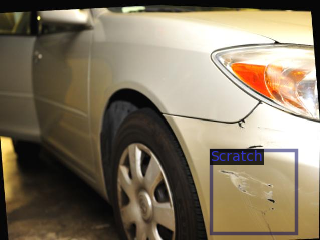

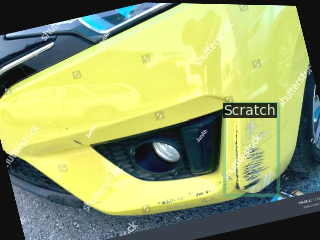

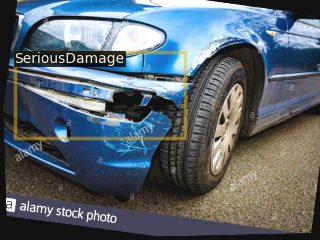

In [7]:
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Train the dataset

Before starting training, we need to make sure that the model validates against our validation set.

In [8]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

https://github.com/facebookresearch/detectron2/tree/main/configs/COCO-Detection

In [14]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer


from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

# obtain detectron2's default config
cfg = get_cfg()
# load values from a file
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4 # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.001 # pick a good LR


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1400 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500) # Error: https://github.com/facebookresearch/detectron2/issues/2609
# cfg.SOLVER.STEPS = []
cfg.SOLVER.GAMMA = 0.05




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/25 03:53:46 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[05/25 03:53:46 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/25 03:54:55 d2.utils.events]:  eta: 1:09:51  iter: 19  total_loss: 1.964  loss_cls: 1.363  loss_box_reg: 0.543  loss_rpn_cls: 0.03825  loss_rpn_loc: 0.01347    time: 2.9934  last_time: 3.2697  data_time: 0.0384  last_data_time: 0.0120   lr: 1.931e-06  max_mem: 11036M
[05/25 03:56:04 d2.utils.events]:  eta: 1:12:41  iter: 39  total_loss: 1.872  loss_cls: 1.305  loss_box_reg: 0.5017  loss_rpn_cls: 0.03015  loss_rpn_loc: 0.01203    time: 3.1430  last_time: 3.3664  data_time: 0.0136  last_data_time: 0.0199   lr: 2.911e-06  max_mem: 11036M
[05/25 03:57:06 d2.utils.events]:  eta: 1:12:05  iter: 59  total_loss: 1.831  loss_cls: 1.248  loss_box_reg: 0.5705  loss_rpn_cls: 0.02581  loss_rpn_loc: 0.01087    time: 3.1319  last_time: 3.3212  data_time: 0.0145  last_data_time: 0.0122   lr: 3.891e-06  max_mem: 11036M
[05/25 03:58:09 d2.utils.events]:  eta: 1:11:32  iter: 79  total_loss: 1.81  loss_cls: 1.178  loss_box_reg: 0.5635  loss_rpn_cls: 0.01469  loss_rpn_loc: 0.01251    time: 3.1391  last

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[05/25 04:20:08 d2.evaluation.evaluator]: Inference done 11/31. Dataloading: 0.0011 s/iter. Inference: 0.2418 s/iter. Eval: 0.0006 s/iter. Total: 0.2435 s/iter. ETA=0:00:04
[05/25 04:20:13 d2.evaluation.evaluator]: Total inference time: 0:00:06.538381 (0.251476 s / iter per device, on 1 devices)
[05/25 04:20:13 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:06 (0.240137 s / iter per device, on 1 devices)
[05/25 04:20:13 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/25 04:20:13 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[05/25 04:20:13 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[05/25 04:20:13 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[05/25 04:20:14 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.05 seconds.
[05/25 04:20:14 d2.evaluation

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[05/25 04:46:33 d2.evaluation.evaluator]: Inference done 11/31. Dataloading: 0.0049 s/iter. Inference: 0.2412 s/iter. Eval: 0.0005 s/iter. Total: 0.2466 s/iter. ETA=0:00:04
[05/25 04:46:38 d2.evaluation.evaluator]: Total inference time: 0:00:06.531780 (0.251222 s / iter per device, on 1 devices)
[05/25 04:46:38 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:06 (0.240307 s / iter per device, on 1 devices)
[05/25 04:46:38 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/25 04:46:38 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[05/25 04:46:38 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/25 04:46:38 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[05/25 04:46:38 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.02 seconds.
[05/25 04:46:38 d2.evaluation

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[05/25 05:07:42 d2.evaluation.evaluator]: Inference done 11/31. Dataloading: 0.0013 s/iter. Inference: 0.2371 s/iter. Eval: 0.0003 s/iter. Total: 0.2387 s/iter. ETA=0:00:04
[05/25 05:07:47 d2.evaluation.evaluator]: Total inference time: 0:00:06.496834 (0.249878 s / iter per device, on 1 devices)
[05/25 05:07:47 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:06 (0.238264 s / iter per device, on 1 devices)
[05/25 05:07:47 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/25 05:07:47 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[05/25 05:07:47 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/25 05:07:47 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[05/25 05:07:47 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.02 seconds.
[05/25 05:07:47 d2.evaluation

Task Complted in 1hr 14m 4s

In [15]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[05/25 05:08:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
WARNING [05/25 05:08:30 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [05/25 05:08:30 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/25 05:08:30 d2.data.datasets.coco]: Loaded 15 images in COCO format from /content/drive/MyDrive/Colab_Notebooks/ObjectDetection/Detectron2/dataset/CarDamage/test/_annotations.coco.json
[05/25 05:08:30 d2.data.build]: Distribution of instances among all 4 categories:
|   category    | #instances   |  category  | #instances   |  category  | #instances   |
|:-------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| CarDamageIn.. | 0            |    Dent    | 1            |  Scratch   | 14           |
| SeriousDamage | 3            |   

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[05/25 05:08:33 d2.evaluation.evaluator]: Inference done 11/15. Dataloading: 0.0013 s/iter. Inference: 0.2301 s/iter. Eval: 0.0004 s/iter. Total: 0.2318 s/iter. ETA=0:00:00
[05/25 05:08:34 d2.evaluation.evaluator]: Total inference time: 0:00:02.474903 (0.247490 s / iter per device, on 1 devices)
[05/25 05:08:34 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.230571 s / iter per device, on 1 devices)
[05/25 05:08:34 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/25 05:08:34 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[05/25 05:08:34 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/25 05:08:34 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[05/25 05:08:34 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[05/25 05:08:34 d2.evaluation.

OrderedDict([('bbox',
              {'AP': 20.487838067961007,
               'AP50': 43.39421938115205,
               'AP75': 2.4752475247524752,
               'APs': nan,
               'APm': nan,
               'APl': 20.487838067961007,
               'AP-CarDamageInstances': nan,
               'AP-Dent': 50.0,
               'AP-Scratch': 11.463514203883037,
               'AP-SeriousDamage': 0.0})])

# Inference

In [16]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

[05/25 05:09:58 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


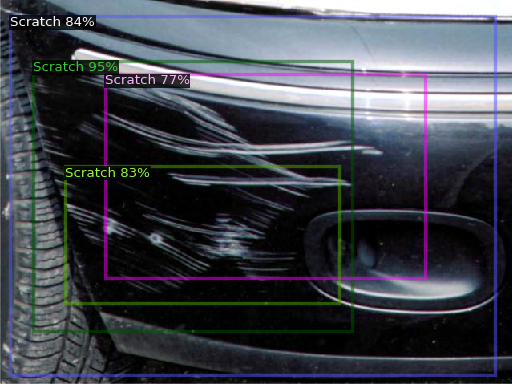

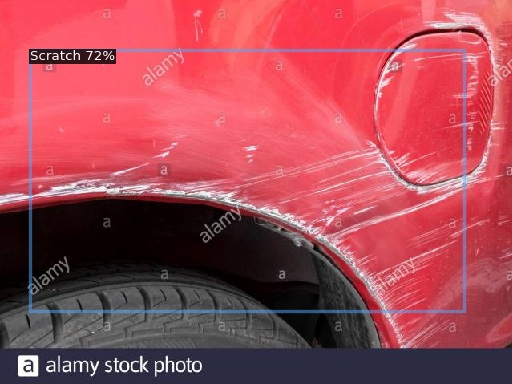

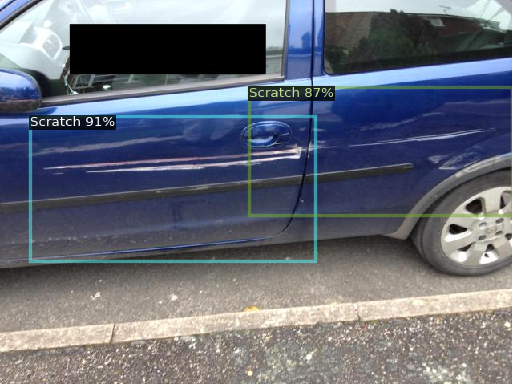

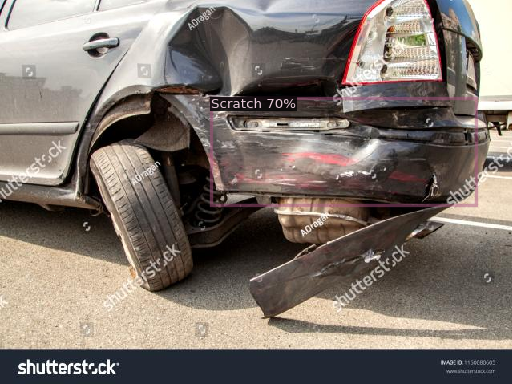

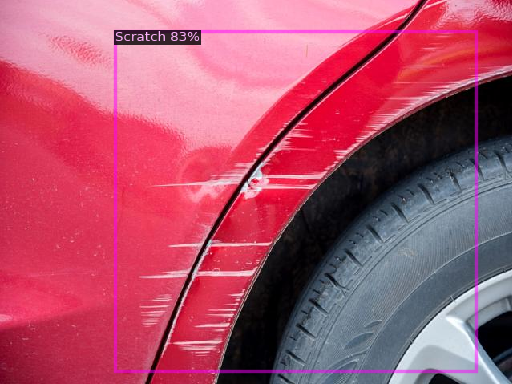

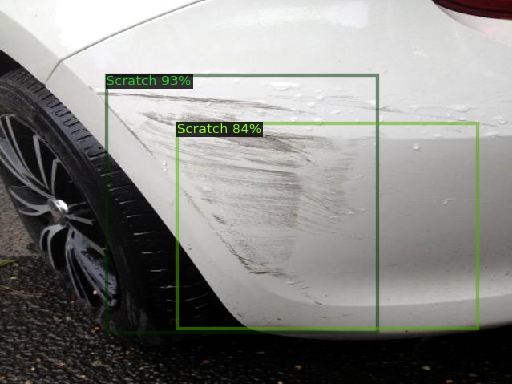

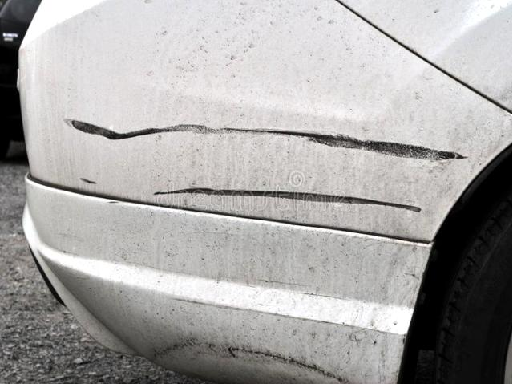

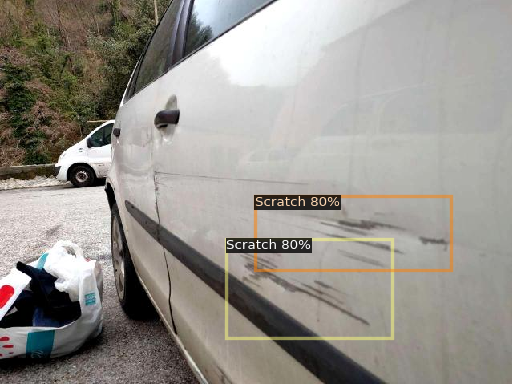

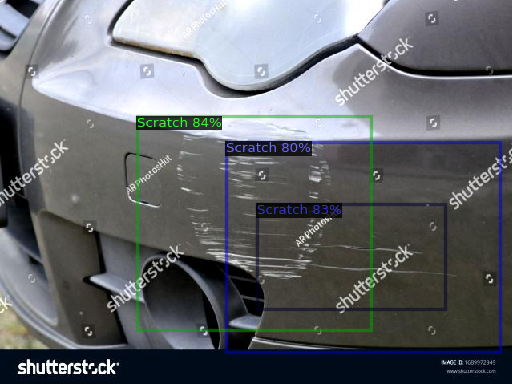

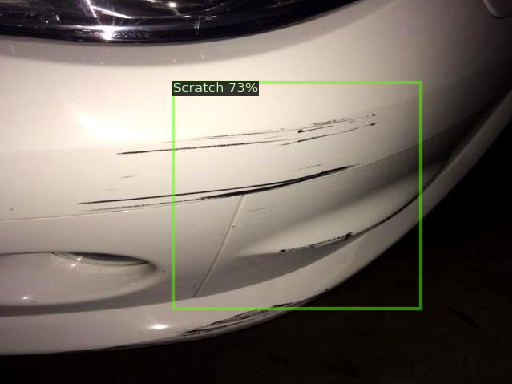

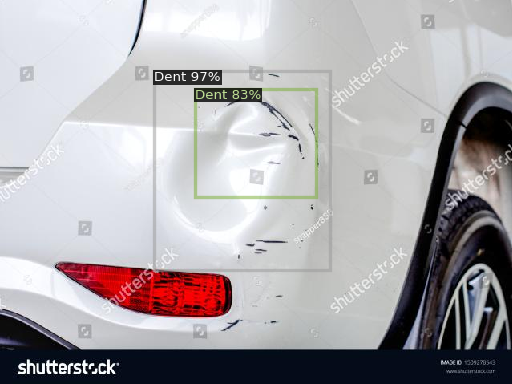

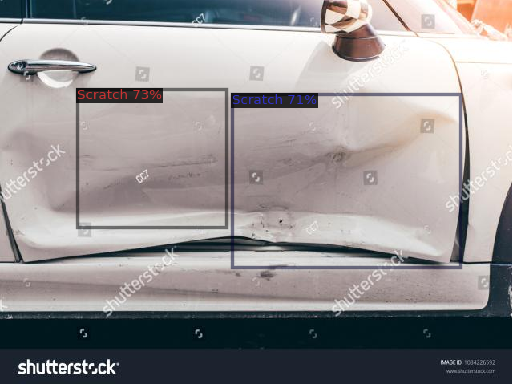

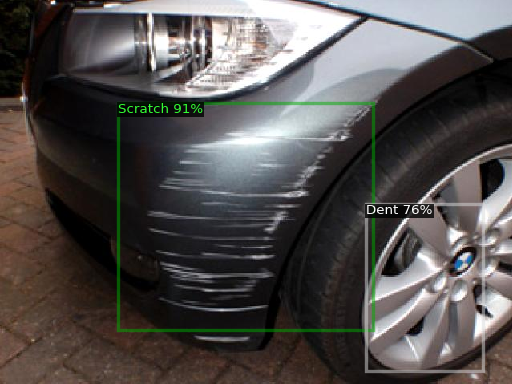

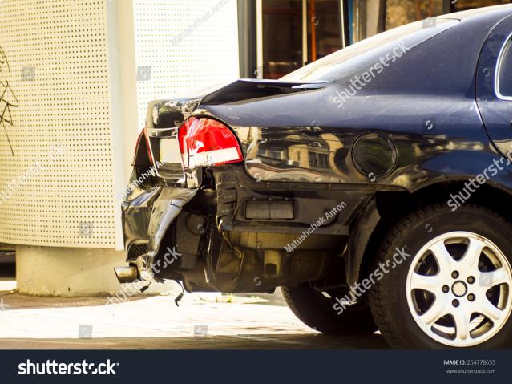

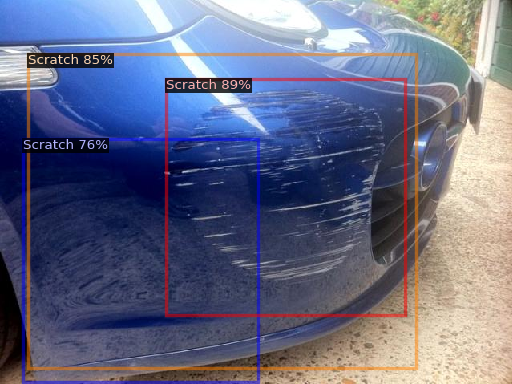

In [17]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/drive/MyDrive/Colab_Notebooks/ObjectDetection/Detectron2/dataset/CarDamage/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])